Name: Kaushik Ilango  
CWID: 20011241  
Course: Natural Language Processing  

Last homework (HW1) I completed the assignment by considering each data point as is that is with the target variable with the range of 1-5. Now I am attempting to complete this assignment by converting the range of target variables to binaries. So overall > 3 will be set to 1 and remaining targets are set to 0. I am not ignoring the rating = 3 rows for this prediction

I am re-using the some of the code and comments from my first homework (HW1)

First obviously we import some basic but necessary libraries for preprocessing and array manipulation.

In [118]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tq

I am gonna use the pandas library to import the provide dataset into this program variable.

In [119]:
amz_rev = pd.read_csv('amazon_reviews.csv')

Let's do some analysis of the product that was reviewed using some simple commands on the amz_rev dataset

In [120]:
amz_rev.head()

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


As we can see there are just two columns (attributes) for each row so just the review statement and the rating. Now let's see the average rating of the product.

In [121]:
sum(amz_rev['overall'])/len(amz_rev['overall'])

4.587589013224822

I am going to convert the target variables to binaries so we can continue with the analytics.

In [122]:
def convert_to_binaries(data) -> pd.DataFrame:
    
    data['overall'] = data['overall'].apply(lambda x: 1 if x > 3 else 0)
    return data

In [123]:
amz_rev = convert_to_binaries(amz_rev)

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
def plot_count(y,xlabel):
    ax = sns.countplot(x = y)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    ax.set_xlabel(xlabel,fontsize=15)

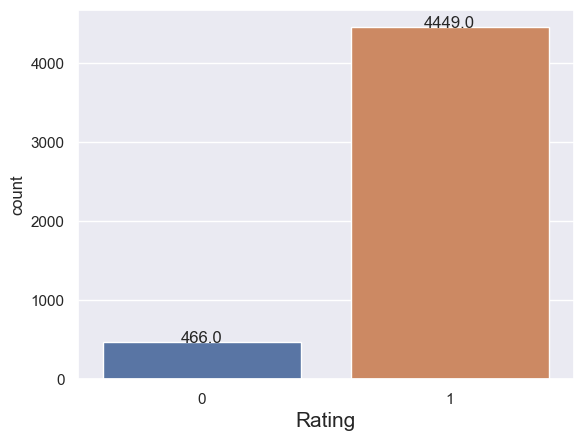

In [125]:
plot_count(amz_rev['overall'],'Rating')
plt.show()

Before we can retrieve more data let's tokenize the review statements so we can gather more insights. For this I am going to directly use the nltk.tokenize module and more specifically the RegexpTokenizer to make it more processable by the model.

In [126]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def setup_data(corpus):
    print("Cleaning data ... ")
    cleaned_corpus = []
    count = 0
    for doc in tq(corpus):
        tokenizer = RegexpTokenizer(r'\w+')
        cleaned_corpus.append(tokenizer.tokenize(doc.lower()))
        count = count + 1
    print(f"Done cleaning {count} data")
    return cleaned_corpus

In [127]:
amz_rev['reviewText'] = amz_rev['reviewText'].replace(np.nan, 'NA', regex=True)
tokenized_data = setup_data(np.array(amz_rev['reviewText']))

Cleaning data ... 


100%|██████████| 4915/4915 [00:00<00:00, 35199.25it/s]

Done cleaning 4915 data


Now we can see the most max used words and least used words to draw some insights.

In [129]:
def draw_insights(corpus):
    min = 0
    max = 0
    total = 0
    for doc in corpus:
        if len(doc) < min:
            min = len(doc)
        if len(doc) > max:
            max = len(doc)
        total = total + len(doc)
    avg = total/len(corpus)
    print(f"Min: {min}, Max: {max}, Avg: {avg}")



In [130]:
draw_insights(tokenized_data)

Min: 0, Max: 1599, Avg: 52.11088504577823


The above results show that the users are dedicated to give a proper review of the product since the avg is at around 52 words which approximately is around 5 lines. Now let's split the data into three parts.

In [132]:
from sklearn.model_selection import train_test_split
def train_test_val_split(X,y, test_size=0.1, val_size = 0.1,random_state=16):
    total_test_size = test_size + val_size
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=total_test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=test_size/total_test_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test


The above function is just a modified function of the usual train_test_split method in model_selection module which I have developed to provide the validation data set as well.

In [133]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(tokenized_data, np.array(amz_rev['overall']))

Let's run the analysis for the same Train, Test and Validation Data sets

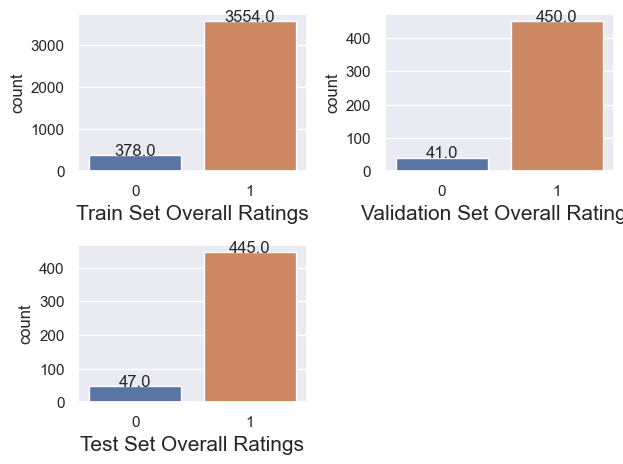

In [134]:
plt.subplot(2,2,1)
plot_count(y_train,xlabel="Train Set Overall Ratings")
plt.subplot(2,2,2)
plot_count(y_val,xlabel="Validation Set Overall Ratings")
plt.subplot(2,2,3)
plot_count(y_test,xlabel="Test Set Overall Ratings")
plt.tight_layout()
plt.show()

Now let's jump into the preprocessing and setting up our embeddings to develop a model. As we have already preprocessed our data using the ```setup_data``` funtion we can use the output to develop a model. Now let's develop a function for retrievinf the vocabulary. There are many ways to do it but I am following the assignment guidelines and using a list comprehension to complete the task.

In [135]:
def get_vocab(corpus):
    vocab = []
    vocab = [x for line in corpus for x in line]
    vocab = list(set(vocab))
    vocab = sorted(vocab)
    return vocab

I have also sorted the words since it was asked to do so which I guess would help in word2index and embedding.

In [136]:
vocab = get_vocab(tokenized_data)

Now let's further dive in and do the complicated part of computing the co-occurence matrix of the whole dataset which would allow us to embed the data and find similarities.

In [141]:
def compute_co_occurence_matrix(corpus,window_size =4):
    word2index = {}
    v = get_vocab(corpus)
    for i in v:
        word2index[i] = v.index(i)
    print(f"Number of unique words {len(v)}")
    x = len(v)
    M = np.zeros((x,x),dtype = 'float32')
    print(M.shape)
    print("Computing pairs...")
    for review in tq(corpus):
        for i in range(len(review)):
            for j in range(max(0,i-window_size),min(i+window_size,len(review))):
                if i!=j:
                    M[word2index[review[i]],word2index[review[j]]] += 1
    return M,word2index

In [142]:
M,word2index = compute_co_occurence_matrix(tokenized_data)

Number of unique words 8516
(8516, 8516)
Computing pairs...


100%|██████████| 4915/4915 [00:05<00:00, 954.08it/s] 


Now we have successfully implemented the co-occurence matrix. Now let's try to reduce the dimensions using SVD in specific as mentioned in the assignment we have to use TruncatedSVD.

FYI, I have used float in the Matrix because its easier for numpy to process and decompose it to lower dimensions than working with integers

In [143]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M,k=2):
    print(f"Reducing to {k} dimensions...")
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=16)
    M_reduced = svd.fit_transform(M)
    return M_reduced

In [144]:
M_reduced = reduce_to_k_dim(M)

Reducing to 2 dimensions...


As mentioned in the assignment we can plot the words using the indices an the 2-d matrix which will provide us with the (x,y) co-ordinates.

In [145]:
def plot_embeddings(M_reduced,word2index,words_to_plot):
    x = []
    y = []
    for word in words_to_plot:
        index = word2index[word]
        x.append(M_reduced[index,0])
        y.append(M_reduced[index,1])
    labels = words_to_plot
    sns.scatterplot(x =x,y = y)
    plt.grid(True)
    for i, label in enumerate(labels):
        plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

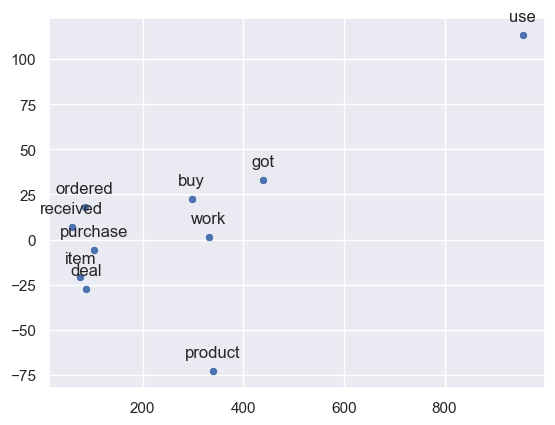

In [146]:
plot_embeddings(M_reduced,word2index,words_to_plot=["purchase", "buy", "work", "got", "ordered", "received", "product", "item", "deal", "use"])

I am not going to add the gensim loaders and pretrained models for this assignments as they are not related to this objective of this homework

Now let's write a definition for computing the average of each word in the review to get a review embedding

In [149]:
def review_embedding(M,word2index,tokenized_reviews):
    print(M_128.shape)
    review_embeddings = []
    embeddings_shape = []
    print("Computing review embeddings...")
    for review in tq(tokenized_reviews):
        embedding = np.mean([M[word2index[w]] for w in review],axis = 0)
        embeddings_shape.append(embedding.shape)
        review_embeddings.append(embedding)
    f = [x for x in embeddings_shape if x != (128,)]
    if f:
        print(f"Warning: {len(f)} review embeddings have shape other than (128,)")
    else:   
        print("All review embeddings have shape (128,)")
    print("Done.")
    return review_embeddings     


Now let's use our embeddings model (co-occurence matrix) to develop a predictive model for the given data set. Let's reduce the dimensions of the matrix M to 128 dimensions to provide more information while still optimizing our run time. I am printing out the shapes just for deubbing since I was getting some errors. But it shows that the each word of shape 128 has been averaged in the review.

In [150]:
M_128 = reduce_to_k_dim(M,k=128)
review_embeddings = review_embedding(M_128,word2index,tokenized_data)

Reducing to 128 dimensions...
(8516, 128)
Computing review embeddings...


100%|██████████| 4915/4915 [00:00<00:00, 20896.71it/s]

All review embeddings have shape (128,)
Done.


Converting it into a numpy array to make it faster for computation.

In [151]:
review_embeddings = np.array(review_embeddings)
review_embeddings.shape

(4915, 128)

Now this is our feature dataset which we can use to develop models

In [152]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(review_embeddings, np.array(amz_rev['overall']))

Let's first build a logistic regression model using scikit library. Since this is multilabel (1-5) we need to set some parameters in the regressor.

In [153]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Now we have the complete pre-processed data we can move on to the model training and model development part. Here we are asked to build an LSTM model as let's do that with pytorch

In [155]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers